In [1]:
##IMPORTS
import pandas as pd
import polars as pl
from collections import Counter
from transformers import pipeline
from googletrans import Translator
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import regex as re
from collections import Counter
from googletrans import Translator
import pickle
import numpy as np

# WEEK 36

In [2]:
#DOWNLOAD DATASET

splits = {'train': 'train.parquet', 'validation': 'validation.parquet'}
df_train = pd.read_parquet("hf://datasets/coastalcph/tydi_xor_rc/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/coastalcph/tydi_xor_rc/" + splits["validation"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Stats

In [3]:
#STATS

#SIZE

langs = ["ar", "ko", "te"]


train_counts = df_train[df_train["lang"].isin(langs)].groupby("lang").size()


val_counts = df_val[df_val["lang"].isin(langs)].groupby("lang").size()

size_df = pd.DataFrame({
    "train_size": train_counts,
    "val_size": val_counts
}).fillna(0).astype(int)

print("Dataset sizes for selected languages:")
print(size_df)



Dataset sizes for selected languages:
      train_size  val_size
lang                      
ar          2558       415
ko          2422       356
te          1355       384


In [4]:

## Each language punctuation
PUNCT_RE = re.compile(r"\p{P}", re.UNICODE)

# ARABIC
ar_train_q = df_train[df_train["lang"] == "ar"]["question"].astype(str)
ar_val_q   = df_val[df_val["lang"] == "ar"]["question"].astype(str)

ar_train_punct = Counter(ch for q in ar_train_q for ch in PUNCT_RE.findall(q))
ar_val_punct   = Counter(ch for q in ar_val_q for ch in PUNCT_RE.findall(q))

print("Arabic — TRAIN punctuation (char -> count):")
print(ar_train_punct.most_common())
print("Arabic — VAL punctuation (char -> count):")
print(ar_val_punct.most_common())

# KOREAN
ko_train_q = df_train[df_train["lang"] == "ko"]["question"].astype(str)
ko_val_q   = df_val[df_val["lang"] == "ko"]["question"].astype(str)

ko_train_punct = Counter(ch for q in ko_train_q for ch in PUNCT_RE.findall(q))
ko_val_punct   = Counter(ch for q in ko_val_q for ch in PUNCT_RE.findall(q))

print("Korean — TRAIN punctuation (char -> count):")
print(ko_train_punct.most_common())
print("Korean — VAL punctuation (char -> count):")
print(ko_val_punct.most_common())

# TELUGU
te_train_q = df_train[df_train["lang"] == "te"]["question"].astype(str)
te_val_q   = df_val[df_val["lang"] == "te"]["question"].astype(str)

te_train_punct = Counter(ch for q in te_train_q for ch in PUNCT_RE.findall(q))
te_val_punct   = Counter(ch for q in te_val_q for ch in PUNCT_RE.findall(q))

print("Telugu — TRAIN punctuation (char -> count):")
print(te_train_punct.most_common())
print("Telugu — VAL punctuation (char -> count):")
print(te_val_punct.most_common())


Arabic — TRAIN punctuation (char -> count):
[('؟', 2556), ('"', 80), ('(', 25), (')', 25), ('-', 5), ('.', 2), ('/', 2), ('«', 2), ('»', 2), ('_', 2), ('\\', 1), ('—', 1), ('!', 1), ('،', 1)]
Arabic — VAL punctuation (char -> count):
[('؟', 413), ('"', 4), ('(', 3), (')', 3), ('،', 1), ('-', 1)]
Korean — TRAIN punctuation (char -> count):
[('?', 2420), (',', 23), ('.', 16), ("'", 6), ('"', 6), ('-', 5), (':', 2), ('/', 1), ('\\', 1), ('(', 1), (')', 1)]
Korean — VAL punctuation (char -> count):
[('?', 356), ('.', 9), (',', 3), ('-', 1)]
Telugu — TRAIN punctuation (char -> count):
[('?', 1355), ('.', 42), (',', 6), ('-', 3), ('%', 1), ('–', 1)]
Telugu — VAL punctuation (char -> count):
[('?', 384), ('.', 2), ('-', 1), ('%', 1)]


In [6]:

## Each language total words (not counting punctuation)
# tokenizer: split on \W+ (non-word chars); protect hyphens between letters/digits
# safeguard: build punctuation set from training+validation data, do not count these tokens as well

SPLIT_RE = re.compile(r"\W+", re.UNICODE)          # tokenizer
HY = "HYPHENJOIN"                                  # placeholder for protected hyphens
PROTECT_HYPHEN = re.compile(r"(?<=[\p{L}\p{N}])-(?=[\p{L}\p{N}])", re.UNICODE)  # hyphen between letters/digits

# ARABIC
ar_train_q = df_train[df_train["lang"] == "ar"]["question"].astype(str)
ar_val_q   = df_val[df_val["lang"] == "ar"]["question"].astype(str)

# build punctuation set (optional safeguard)
ar_punct_set = set(ch for q in pd.concat([ar_train_q, ar_val_q]) for ch in PUNCT_RE.findall(q))

# protect hyphens, split on \W+, restore hyphens; slashes will split
ar_train_tokens = []
for q in ar_train_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in ar_punct_set]
    ar_train_tokens.extend(toks)

ar_val_tokens = []
for q in ar_val_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in ar_punct_set]
    ar_val_tokens.extend(toks)

print("Arabic — TRAIN total words:", len(ar_train_tokens))
print("Arabic — VAL total words:",   len(ar_val_tokens))

# KOREAN
ko_train_q = df_train[df_train["lang"] == "ko"]["question"].astype(str)
ko_val_q   = df_val[df_val["lang"] == "ko"]["question"].astype(str)

ko_punct_set = set(ch for q in pd.concat([ko_train_q, ko_val_q]) for ch in PUNCT_RE.findall(q))

ko_train_tokens = []
for q in ko_train_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in ko_punct_set]
    ko_train_tokens.extend(toks)

ko_val_tokens = []
for q in ko_val_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in ko_punct_set]
    ko_val_tokens.extend(toks)

print("Korean — TRAIN total words:", len(ko_train_tokens))
print("Korean — VAL total words:",   len(ko_val_tokens))

# TELUGU
te_train_q = df_train[df_train["lang"] == "te"]["question"].astype(str)
te_val_q   = df_val[df_val["lang"] == "te"]["question"].astype(str)

te_punct_set = set(ch for q in pd.concat([te_train_q, te_val_q]) for ch in PUNCT_RE.findall(q))

te_train_tokens = []
for q in te_train_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in te_punct_set]
    te_train_tokens.extend(toks)

te_val_tokens = []
for q in te_val_q:
    q2 = PROTECT_HYPHEN.sub(HY, q)
    toks = [t.replace(HY, "-") for t in SPLIT_RE.split(q2) if t and t not in te_punct_set]
    te_val_tokens.extend(toks)

print("Telugu — TRAIN total words:", len(te_train_tokens))
print("Telugu — VAL total words:",   len(te_val_tokens))


Arabic — TRAIN total words: 16199
Arabic — VAL total words: 2617
Korean — TRAIN total words: 11858
Korean — VAL total words: 1736
Telugu — TRAIN total words: 7690
Telugu — VAL total words: 2302


In [7]:
#Stats on numeric and hyphenated tokens

# ---- After tokenization for Arabic ----
ar_numbers_train = sum(1 for t in ar_train_tokens if t.isdigit())
ar_numbers_val   = sum(1 for t in ar_val_tokens if t.isdigit())

ar_hyphen_train = sum(1 for t in ar_train_tokens if "-" in t)
ar_hyphen_val   = sum(1 for t in ar_val_tokens if "-" in t)

print("Arabic — numeric tokens (train):", ar_numbers_train)
print("Arabic — numeric tokens (val):",   ar_numbers_val)
print("Arabic — hyphenated tokens (train):", ar_hyphen_train)
print("Arabic — hyphenated tokens (val):",   ar_hyphen_val)

# ---- After tokenization for Korean ----
ko_numbers_train = sum(1 for t in ko_train_tokens if t.isdigit())
ko_numbers_val   = sum(1 for t in ko_val_tokens if t.isdigit())

ko_hyphen_train = sum(1 for t in ko_train_tokens if "-" in t)
ko_hyphen_val   = sum(1 for t in ko_val_tokens if "-" in t)

print("Korean — numeric tokens (train):", ko_numbers_train)
print("Korean — numeric tokens (val):",   ko_numbers_val)
print("Korean — hyphenated tokens (train):", ko_hyphen_train)
print("Korean — hyphenated tokens (val):",   ko_hyphen_val)

# ---- After tokenization for Telugu ----
te_numbers_train = sum(1 for t in te_train_tokens if t.isdigit())
te_numbers_val   = sum(1 for t in te_val_tokens if t.isdigit())

te_hyphen_train = sum(1 for t in te_train_tokens if "-" in t)
te_hyphen_val   = sum(1 for t in te_val_tokens if "-" in t)

print("Telugu — numeric tokens (train):", te_numbers_train)
print("Telugu — numeric tokens (val):",   te_numbers_val)
print("Telugu — hyphenated tokens (train):", te_hyphen_train)
print("Telugu — hyphenated tokens (val):",   te_hyphen_val)


Arabic — numeric tokens (train): 78
Arabic — numeric tokens (val): 11
Arabic — hyphenated tokens (train): 3
Arabic — hyphenated tokens (val): 0
Korean — numeric tokens (train): 9
Korean — numeric tokens (val): 1
Korean — hyphenated tokens (train): 5
Korean — hyphenated tokens (val): 1
Telugu — numeric tokens (train): 107
Telugu — numeric tokens (val): 39
Telugu — hyphenated tokens (train): 0
Telugu — hyphenated tokens (val): 0


In [8]:
#5 Most common words (not counting punctuation); with English translations and their count

translator = Translator()

# ARABIC
# (skip pure numbers)
ar_counts = Counter([t.lower() for t in ar_train_tokens if t ])
ar_top5 = ar_counts.most_common(5)

print("Arabic — Top 5 most common words (TRAIN):")
for w, c in ar_top5:
    try:
        en = translator.translate(w, src='ar', dest='en').text
    except Exception as e:
        en = f"[translation error: {e}]"
    print(f"{w}\tcount={c}\t→ {en}")

# KOREAN
ko_counts = Counter([t.lower() for t in ko_train_tokens if t ])
ko_top5 = ko_counts.most_common(5)

print("\nKorean — Top 5 most common words (TRAIN):")
for w, c in ko_top5:
    try:
        en = translator.translate(w, src='ko', dest='en').text
    except Exception as e:
        en = f"[translation error: {e}]"
    print(f"{w}\tcount={c}\t→ {en}")

#  TELUGU
te_counts = Counter([t.lower() for t in te_train_tokens if t])
te_top5 = te_counts.most_common(5)

print("\nTelugu — Top 5 most common words (TRAIN):")
for w, c in te_top5:
    try:
        en = translator.translate(w, src='te', dest='en').text
    except Exception as e:
        en = f"[translation error: {e}]"
    print(f"{w}\tcount={c}\t→ {en}")


Arabic — Top 5 most common words (TRAIN):
في	count=593	→ in
من	count=587	→ from
متى	count=536	→ when
ما	count=443	→ what
هو	count=350	→ he

Korean — Top 5 most common words (TRAIN):
가장	count=527	→ most
무엇인가	count=497	→ Something
언제	count=336	→ when
몇	count=234	→ some
어디인가	count=228	→ Where

Telugu — Top 5 most common words (TRAIN):
ఎవరు	count=274	→ Who is
ఏది	count=192	→ Which one is
ఎన్ని	count=165	→ How many
ఎప్పుడు	count=154	→ When
ఏ	count=144	→ A.


### We conclude the words are "stop words" that we learned in the lecture

In [10]:
# Stats about answerable vs unanswerable questions

# Define languages and splits

split_dfs = {
    "train": df_train,
    "val":   df_val
}


rows = []
for split_name, df in split_dfs.items():
    for lang in langs:
        total = df[df["lang"] == lang].shape[0]
        ans   = df[(df["lang"] == lang) & (df["answerable"])].shape[0]
        unans = total - ans
        ratio = ans / total if total > 0 else 0
        rows.append([split_name, lang, total, ans, unans, ratio])

# Create summary DataFrame
summary = pd.DataFrame(rows, columns=["Split", "Language", "Total", "Answerable", "Unanswerable", "Answerable Ratio"])
print(summary.to_string(index=False))


Split Language  Total  Answerable  Unanswerable  Answerable Ratio
train       ar   2558        2303           255          0.900313
train       ko   2422        2359            63          0.973988
train       te   1355        1310            45          0.966790
  val       ar    415         363            52          0.874699
  val       ko    356         337            19          0.946629
  val       te    384         291            93          0.757812


## RULE BASE CLASSIFIER

In [21]:
import os
import numpy as np
import pandas as pd
import regex as re
import string
from unidecode import unidecode

import nltk
nltk.download("stopwords", quiet=True)
# Needed for word_tokenize
try:
    nltk.download("punkt", quiet=True)
    # Some NLTK builds need this extra package
    nltk.download("punkt_tab", quiet=True)
except Exception:
    pass

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

EN_STOP = set(stopwords.words('english')) | set(string.punctuation)

# If you haven't already created these:
# df_train = pd.read_csv("path/to/train.csv")  # or load however you have it
# df_val   = pd.read_csv("path/to/val.csv")

# Languages you care about
LANGS = ["ar", "ko", "te"]


In [22]:
import torch
from transformers import pipeline

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
DEVICE = 0 if torch.cuda.is_available() else -1
print("Using device idx for HF pipeline:", DEVICE)

MODEL_ID = "facebook/nllb-200-distilled-600M"
SRC_CODES = {"ar": "arb_Arab", "ko": "kor_Hang", "te": "tel_Telu"}
TGT_CODE = "eng_Latn"

# One translator pipeline reused for all batches
nllb = pipeline("translation", model=MODEL_ID, tokenizer=MODEL_ID, device=DEVICE)


PyTorch: 2.8.0+cu126
CUDA available: True
Using device idx for HF pipeline: 0


Device set to use cuda:0


In [23]:
from typing import List, Iterable, Dict, Optional
from tqdm import tqdm

def translate_list_pipe(texts: List[str],
                        src_lang: str,
                        batch_size: int = 128,
                        max_length: int = 320,
                        show_progress: bool = True) -> List[str]:
    """
    Translate a list of strings to English using NLLB. Robust to errors; returns "" on failure.
    Assumes src_lang is one of LANGS and uses SRC_CODES mapping.
    """
    if src_lang not in SRC_CODES:
        raise ValueError(f"Unknown lang code '{src_lang}'. Expected one of {list(SRC_CODES)}")

    outputs = []
    iterator = range(0, len(texts), batch_size)
    if show_progress:
        iterator = tqdm(iterator, total=(len(texts) + batch_size - 1)//batch_size, desc=f"Translating {src_lang}->EN")

    for i in iterator:
        batch = [x if isinstance(x, str) else "" for x in texts[i:i+batch_size]]
        try:
            preds = nllb(
                batch,
                src_lang=SRC_CODES[src_lang],
                tgt_lang=TGT_CODE,
                truncation=True,
                max_length=max_length
            )
            outputs.extend([p.get("translation_text", "") for p in preds])
        except Exception as e:
            print(f"[WARN] Batch {i}:{i+len(batch)} failed: {type(e).__name__}: {e}")
            outputs.extend([""] * len(batch))
    return outputs


In [24]:
def ensure_column(df: pd.DataFrame, col: str):
    if col not in df.columns:
        df[col] = pd.Series([np.nan]*len(df), index=df.index)

# Ensure the target columns exist
ensure_column(df_train, "question_en")
ensure_column(df_val,   "question_en")

# Toggle if you want to translate contexts too (usually NOT needed for TyDi XOR RC)
TRANSLATE_CONTEXT = False
if TRANSLATE_CONTEXT:
    ensure_column(df_train, "context_en")
    ensure_column(df_val,   "context_en")

def cache_translations(df: pd.DataFrame,
                       text_col: str,
                       out_col: str,
                       langs: Iterable[str] = LANGS,
                       batch_size: int = 128):
    """
    For each lang in langs, fills df[out_col] with EN translations of df[text_col] where it's missing/NaN.
    """
    for lg in langs:
        mask_lang = (df["lang"] == lg)
        mask_need = df[out_col].isna() | (df[out_col].astype(str).str.strip() == "")
        mask = mask_lang & mask_need
        if not mask.any():
            print(f"[{text_col}] '{lg}' — already cached, skipping.")
            continue

        texts = df.loc[mask, text_col].astype(str).tolist()
        print(f"[{text_col}] Translating {sum(mask)} rows for lang='{lg}'...")
        df.loc[mask, out_col] = translate_list_pipe(texts, src_lang=lg, batch_size=batch_size)

# Cache questions
cache_translations(df_train, text_col="question", out_col="question_en", batch_size=128)
cache_translations(df_val,   text_col="question", out_col="question_en", batch_size=128)

# Optionally cache contexts (only if you set TRANSLATE_CONTEXT=True)
if TRANSLATE_CONTEXT:
    cache_translations(df_train, text_col="context", out_col="context_en", batch_size=128)
    cache_translations(df_val,   text_col="context", out_col="context_en", batch_size=128)

# (Optional) Persist to disk so you never re-translate again
df_train.to_parquet("df_train_translated.parquet")
df_val.to_parquet("df_val_translated.parquet")
print("Saved: df_train_translated.parquet, df_val_translated.parquet")


[question] Translating 2558 rows for lang='ar'...


Translating ar->EN: 100%|██████████| 20/20 [12:59<00:00, 39.00s/it]
/tmp/ipython-input-2770176389.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['When did Russia intervene in the Syrian civil war?', 'When did Hungary gain its independence from Austria ?', 'When did France and Great Britain unite against Germany in war?', 'How many casualties in the first Israeli attack on Gaza City ?', 'Is the Harry Potter series against the laws of Christianity ?', 'How many were the victims of the Spanish occupation of South America ?', 'Is higher education free in the United States?', 'Is Islam forbidden to consider women as merchants?', 'What was the first U.S. state to legalize same-sex marriage ?', "Why did the United States oppose Israel's declaration of Jerusalem as its capital in 1949?", 'How long did it take to plan the Iraq war in the United States ?', 'Why did Russia interfere in the Syrian conflict ?'

[question] Translating 2422 rows for lang='ko'...


Translating ko->EN: 100%|██████████| 19/19 [11:19<00:00, 35.76s/it]


[question] Translating 1355 rows for lang='te'...


Translating te->EN: 100%|██████████| 11/11 [06:48<00:00, 37.10s/it]


[question] Translating 415 rows for lang='ar'...


Translating ar->EN: 100%|██████████| 4/4 [01:58<00:00, 29.73s/it]
/tmp/ipython-input-2770176389.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['What are the first universities in Finland?', 'How many countries are on the Baltic Sea?', 'Where did Newton live?', 'Has the puppy visited Yemen?', 'Who is the first president of the Republic of Yemen?', 'When did the war in Normandy end ?', 'Who is the explorer who found Resurrection Island in the South Pacific?', "What are Mary Wollstonecraft 's most famous works ?", "Where did the Qur'an come down?", 'Why is the Finnish education system one of the best?', 'What is a football team in France?', 'The year Mahatma Gandhi died?', 'What is the most dangerous shark species ?', "What's the smallest island in the world?", 'What is the number of days in the month of Ramadan ?', "How much does Big Ben's watch weigh?", 'How many major divisions of Christianity are

[question] Translating 356 rows for lang='ko'...


Translating ko->EN: 100%|██████████| 3/3 [01:39<00:00, 33.15s/it]


[question] Translating 384 rows for lang='te'...


Translating te->EN: 100%|██████████| 3/3 [01:52<00:00, 37.45s/it]

Saved: df_train_translated.parquet, df_val_translated.parquet


In [25]:
def sanity_check_translations(df, text_col="question", trans_col="question_en", langs=LANGS, n=3):
    """
    Prints n sample original vs. translated texts for each language to verify translation.
    """
    for lg in langs:
        subset = df[df["lang"] == lg].dropna(subset=[text_col, trans_col])
        if subset.empty:
            print(f"[WARN] No data for lang '{lg}' in {text_col}")
            continue

        print(f"\n=== {lg.upper()} → EN (showing {n} samples) ===")
        for i, row in subset.head(n).iterrows():
            print("SRC:", row[text_col])
            print("EN :", row[trans_col])
            print("-"*40)

# Run sanity check on train set
sanity_check_translations(df_train, text_col="question", trans_col="question_en", langs=LANGS, n=3)

# Optionally check val set too
sanity_check_translations(df_val, text_col="question", trans_col="question_en", langs=LANGS, n=3)



=== AR → EN (showing 3 samples) ===
SRC: متى تدخلت روسيا في  الحرب الأهلية السورية؟
EN : When did Russia intervene in the Syrian civil war?
----------------------------------------
SRC: متى حصلت هنغاريا على استقلالها من النمسا ؟
EN : When did Hungary gain its independence from Austria ?
----------------------------------------
SRC: متى تحالفت فرنسا و بريطانيا العظمى ضد ألمانيا في حرب؟
EN : When did France and Great Britain unite against Germany in war?
----------------------------------------

=== KO → EN (showing 3 samples) ===
SRC: 30년 전쟁의 승자는 누구인가?
EN : Who is the winner of the Thirty Years' War?
----------------------------------------
SRC: 엑스선은 누가 발견하였는가?
EN : Who discovered X-rays?
----------------------------------------
SRC: 아테네에서 언제 가장 최근의 올림픽이 올렸나요?
EN : When was the last Olympic Games held in Athens?
----------------------------------------

=== TE → EN (showing 3 samples) ===
SRC: ప్రపంచంలో  మొట్టమొదటి దూర విద్య విద్యాలయం ఏ దేశంలో స్థాపించబడింది ?
EN : The world's first di

In [26]:
# ---- tokenization helpers ----
def tok_en_rm_stop(text: str):
    if not isinstance(text, str): return []
    toks = word_tokenize(text, language="english", preserve_line=True)
    return [t.lower() for t in toks if t and t.lower() not in EN_STOP]

def tok_en_keep_all(text: str):
    if not isinstance(text, str): return []
    toks = word_tokenize(text, language="english", preserve_line=True)
    return [t.lower() for t in toks if t]

# ---- text normalization / features ----
ALNUM = re.compile(r"[a-z0-9]+")
def ascii_alnum(s):
    s2 = unidecode((s or "").lower())
    return " ".join(ALNUM.findall(s2))

def char_ngrams(s, n=3):
    s = s.replace(" ", "")
    return [s[i:i+n] for i in range(max(0, len(s)-n+1))]

NUM_RE = re.compile(r"\d{2,}")  # match 2+ digit numbers (years, counts)

def build_features(q_texts, c_texts, q_toks, c_toks):
    """
    Return Nx5 features: [overlap, jaccard, has_num, has_long, char3]
    """
    F = []
    for qx, cx, q, c in zip(q_texts, c_texts, q_toks, c_toks):
        qs, cs = set(q), set(c)
        inter = len(qs & cs)
        overlap = inter / max(1, len(q))
        jacc   = inter / max(1, len(qs | cs))

        # numbers on RAW strings
        q_nums = set(NUM_RE.findall(qx or ""))
        has_num  = 1.0 if any(n in (cx or "") for n in q_nums) else 0.0

        # long token anchor (>=5 chars) present in context tokens
        has_long = 1.0 if any((len(t) >= 5 and t in cs) for t in q) else 0.0

        # char-3-gram overlap on ascii-folded RAW strings
        qa, ca = ascii_alnum(qx or ""), ascii_alnum(cx or "")
        q3 = set(char_ngrams(qa, 3))
        char3 = (sum(g in ca for g in q3)/len(q3)) if q3 else 0.0

        F.append((overlap, jacc, has_num, has_long, char3))
    return np.array(F, float)

def score(F):
    # weights: emphasize token overlap + char3; support from numbers/long; small jaccard
    w = np.array([0.40, 0.05, 0.20, 0.10, 0.25], float)
    return (F*w).sum(axis=1)

def best_threshold(scores, gold):
    best_t, best_f1 = 0.0, -1.0
    for T in np.linspace(0, 1, 101):
        pred = scores >= T
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        if f1 > best_f1:
            best_f1, best_t = f1, T
    return float(best_t), float(best_f1)


In [27]:
def eval_language_rule_based_cached(lang_code: str,
                                    translate_contexts: bool = False):
    """
    Uses df_train/df_val with cached columns:
      - question_en (required)
      - context_en  (optional; if not present or translate_contexts=False, uses raw context)
    """
    # 1) slice data
    tr = df_train[df_train["lang"]==lang_code].copy()
    va = df_val[df_val["lang"]==lang_code].copy()

    if "question_en" not in tr.columns or "question_en" not in va.columns:
        raise RuntimeError("Missing 'question_en' cached column. Run the translation caching cell first.")

    # 2) questions are already translated & cached
    tr_q_en = tr["question_en"].astype(str).tolist()
    va_q_en = va["question_en"].astype(str).tolist()

    # 3) contexts: either keep as-is (English already) or use cached if you created 'context_en'
    if translate_contexts and ("context_en" in tr.columns) and ("context_en" in va.columns):
        tr_c_en = tr["context_en"].astype(str).tolist()
        va_c_en = va["context_en"].astype(str).tolist()
    else:
        tr_c_en = tr["context"].astype(str).tolist()
        va_c_en = va["context"].astype(str).tolist()

    # 4) tokenize: remove stops in Q, keep all tokens in C
    tr_q_tok = [tok_en_rm_stop(s) for s in tr_q_en]
    va_q_tok = [tok_en_rm_stop(s) for s in va_q_en]
    tr_c_tok = [tok_en_keep_all(s) for s in tr_c_en]
    va_c_tok = [tok_en_keep_all(s) for s in va_c_en]

    # 5) features → scores → threshold on train
    F_tr = build_features(tr_q_en, tr_c_en, tr_q_tok, tr_c_tok)
    s_tr = score(F_tr)
    T, f1_tr = best_threshold(s_tr, tr["answerable"].astype(int).values)

    # 6) eval on val
    F_va = build_features(va_q_en, va_c_en, va_q_tok, va_c_tok)
    s_va = score(F_va)
    pred = (s_va >= T).astype(int)
    gold = va["answerable"].astype(int).values

    tp = int(((pred==1)&(gold==1)).sum())
    fp = int(((pred==1)&(gold==0)).sum())
    fn = int(((pred==0)&(gold==1)).sum())
    tn = int(((pred==0)&(gold==0)).sum())

    acc  = (tp+tn)/max(1, tp+tn+fp+fn)
    prec = tp/max(1, tp+fp)
    rec  = tp/max(1, tp+fn)
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

    return {
        "lang": lang_code,
        "threshold": round(T,3),
        "train_F1_at_T": round(f1_tr,4),
        "val_acc": round(acc,4),
        "val_prec": round(prec,4),
        "val_rec": round(rec,4),
        "val_f1": round(f1,4),
        "cm": {"TP":tp,"FP":fp,"FN":fn,"TN":tn},
        "score_min_max_train": (float(s_tr.min()), float(s_tr.max())),
        "score_min_max_val": (float(s_va.min()), float(s_va.max())),
    }


In [28]:
results = [eval_language_rule_based_cached(l, translate_contexts=False) for l in LANGS]

summary = pd.DataFrame([{k:v for k,v in r.items() if k not in ("cm","score_min_max_train","score_min_max_val")} for r in results])
print(summary.to_string(index=False))

print("\nConfusion matrices:")
for r in results:
    print(r["lang"], r["cm"])

print("\nScore ranges:")
for r in results:
    print(r["lang"], "train", r["score_min_max_train"], "| val", r["score_min_max_val"])


lang  threshold  train_F1_at_T  val_acc  val_prec  val_rec  val_f1
  ar        0.0         0.9475   0.8747    0.8747      1.0  0.9332
  ko        0.0         0.9868   0.9466    0.9466      1.0  0.9726
  te        0.0         0.9831   0.7578    0.7578      1.0  0.8622

Confusion matrices:
ar {'TP': 363, 'FP': 52, 'FN': 0, 'TN': 0}
ko {'TP': 337, 'FP': 19, 'FN': 0, 'TN': 0}
te {'TP': 291, 'FP': 93, 'FN': 0, 'TN': 0}

Score ranges:
ar train (0.0, 0.8660556257901391) | val (0.0, 0.7391711229946525)
ko train (0.0, 0.8530769230769231) | val (0.0, 0.7826373626373626)
te train (0.005434782608695652, 0.8619978858350952) | val (0.0, 0.8707661290322581)


In [29]:
import pandas as pd

def class_balance_report(df, name="df", langs=("ar","ko","te")):
    rows = []
    for lg in langs:
        sub = df[df["lang"]==lg]
        pos = int((sub["answerable"]==1).sum())
        neg = int((sub["answerable"]==0).sum())
        rows.append({
            "split": name, "lang": lg, "n": len(sub),
            "positives": pos, "negatives": neg,
            "pos_%": round(100*pos/max(1,len(sub)),2)
        })
    return pd.DataFrame(rows)

display(class_balance_report(df_train, "train"))
display(class_balance_report(df_val,   "val"))


,split,lang,n,positives,negatives,pos_%
0,train,ar,2558,2303,255,90.03
1,train,ko,2422,2359,63,97.40
2,train,te,1355,1310,45,96.68


,split,lang,n,positives,negatives,pos_%
0,val,ar,415,363,52,87.47
1,val,ko,356,337,19,94.66
2,val,te,384,291,93,75.78


In [30]:
import numpy as np

def compute_scores_for_lang(lang_code, translate_contexts=False):
    tr = df_train[df_train["lang"]==lang_code].copy()
    va = df_val[df_val["lang"]==lang_code].copy()

    tr_q_en = tr["question_en"].astype(str).tolist()
    va_q_en = va["question_en"].astype(str).tolist()

    if translate_contexts and ("context_en" in tr.columns) and ("context_en" in va.columns):
        tr_c_en = tr["context_en"].astype(str).tolist()
        va_c_en = va["context_en"].astype(str).tolist()
    else:
        tr_c_en = tr["context"].astype(str).tolist()
        va_c_en = va["context"].astype(str).tolist()

    tr_q_tok = [tok_en_rm_stop(s) for s in tr_q_en]
    va_q_tok = [tok_en_rm_stop(s) for s in va_q_en]
    tr_c_tok = [tok_en_keep_all(s) for s in tr_c_en]
    va_c_tok = [tok_en_keep_all(s) for s in va_c_en]

    F_tr = build_features(tr_q_en, tr_c_en, tr_q_tok, tr_c_tok)
    F_va = build_features(va_q_en, va_c_en, va_q_tok, va_c_tok)

    s_tr = score(F_tr)
    s_va = score(F_va)
    y_tr = tr["answerable"].astype(int).values
    y_va = va["answerable"].astype(int).values
    return s_tr, y_tr, s_va, y_va

scores = {}
for lg in ["ar","ko","te"]:
    scores[lg] = compute_scores_for_lang(lg, translate_contexts=False)

print({lg: (float(scores[lg][0].min()), float(scores[lg][0].max())) for lg in scores})


{'ar': (0.0, 0.8660556257901391), 'ko': (0.0, 0.8530769230769231), 'te': (0.005434782608695652, 0.8619978858350952)}


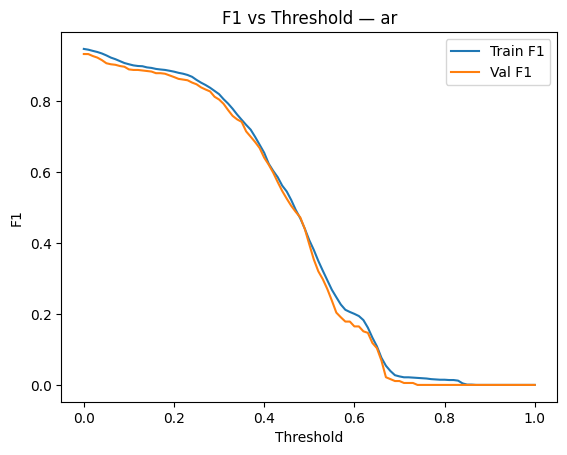

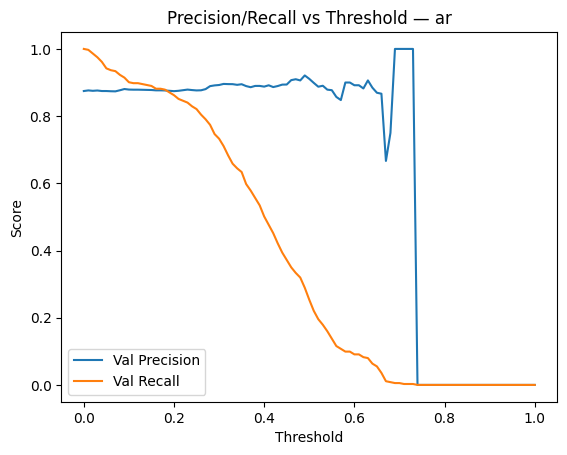

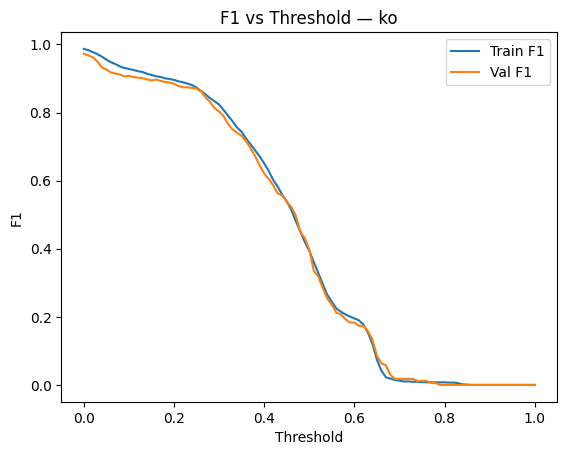

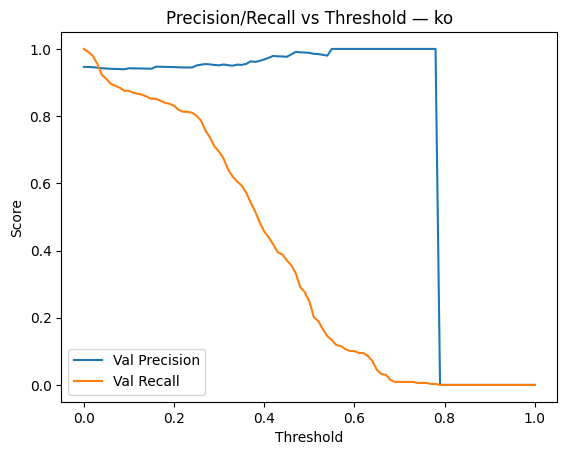

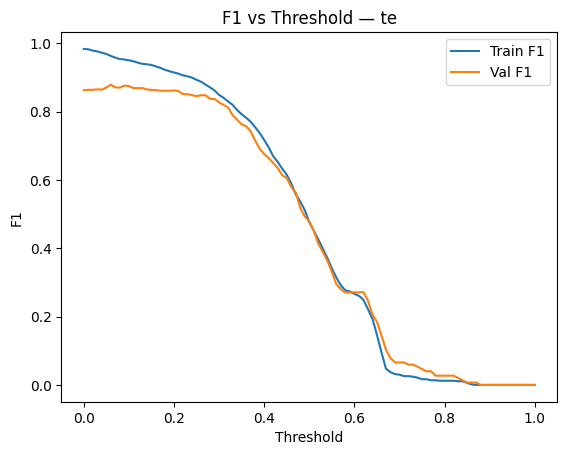

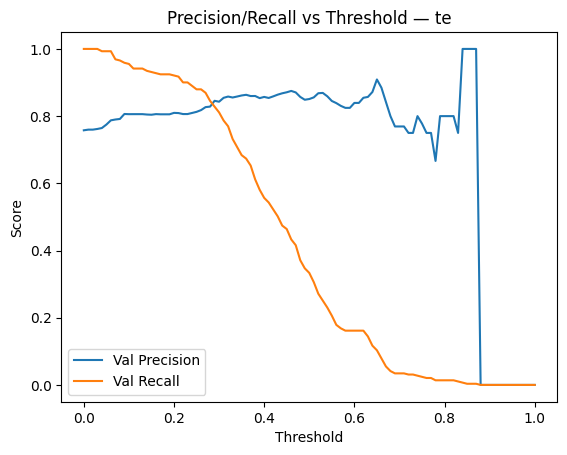

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def metrics_over_threshold(scores, gold, steps=101):
    Ts = np.linspace(0, 1, steps)
    pr, rc, f1 = [], [], []
    for T in Ts:
        pred = (scores >= T).astype(int)
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1v  = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        pr.append(prec); rc.append(rec); f1.append(f1v)
    return Ts, np.array(pr), np.array(rc), np.array(f1)

for lg in ["ar","ko","te"]:
    s_tr, y_tr, s_va, y_va = scores[lg]

    Ts, pr_tr, rc_tr, f1_tr = metrics_over_threshold(s_tr, y_tr)
    Ts, pr_va, rc_va, f1_va = metrics_over_threshold(s_va, y_va)

    # Plot F1 (validation) — use this to pick T
    plt.figure()
    plt.plot(Ts, f1_tr, label="Train F1")
    plt.plot(Ts, f1_va, label="Val F1")
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.title(f"F1 vs Threshold — {lg}")
    plt.legend()
    plt.show()

    # Optional: also look at precision/recall curves on val
    plt.figure()
    plt.plot(Ts, pr_va, label="Val Precision")
    plt.plot(Ts, rc_va, label="Val Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision/Recall vs Threshold — {lg}")
    plt.legend()
    plt.show()


In [32]:
def evaluate_at_threshold(scores, gold, T):
    pred = (scores >= T).astype(int)
    tp = int(np.sum((pred==1)&(gold==1)))
    fp = int(np.sum((pred==1)&(gold==0)))
    fn = int(np.sum((pred==0)&(gold==1)))
    tn = int(np.sum((pred==0)&(gold==0)))
    acc  = (tp+tn)/max(1, tp+tn+fp+fn)
    prec = tp/max(1, tp+fp)
    rec  = tp/max(1, tp+fn)
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"cm":{"TP":tp,"FP":fp,"FN":fn,"TN":tn}}

# choose manual thresholds per language (read from plots)
manual_T = {"ar": 0.25, "ko": 0.25, "te": 0.35}  # <-- tweak these

for lg in ["ar","ko","te"]:
    s_tr, y_tr, s_va, y_va = scores[lg]
    print(f"\n[{lg}] Train @T={manual_T[lg]}:", evaluate_at_threshold(s_tr, y_tr, manual_T[lg]))
    print(f"[{lg}]   Val @T={manual_T[lg]}:",   evaluate_at_threshold(s_va, y_va, manual_T[lg]))



[ar] Train @T=0.25: {'acc': 0.7599687255668491, 'prec': 0.9046478198370868, 'rec': 0.8198002605297439, 'f1': 0.8601366742596811, 'cm': {'TP': 1888, 'FP': 199, 'FN': 415, 'TN': 56}}
[ar]   Val @T=0.25: {'acc': 0.7421686746987952, 'prec': 0.8764705882352941, 'rec': 0.8209366391184573, 'f1': 0.8477951635846372, 'cm': {'TP': 298, 'FP': 42, 'FN': 65, 'TN': 10}}

[ko] Train @T=0.25: {'acc': 0.7758051197357556, 'prec': 0.9739039665970772, 'rec': 0.7910131411615091, 'f1': 0.8729824561403509, 'cm': {'TP': 1866, 'FP': 50, 'FN': 493, 'TN': 13}}
[ko]   Val @T=0.25: {'acc': 0.7724719101123596, 'prec': 0.9507042253521126, 'rec': 0.8011869436201781, 'f1': 0.8695652173913043, 'cm': {'TP': 270, 'FP': 14, 'FN': 67, 'TN': 5}}

[te] Train @T=0.35: {'acc': 0.6605166051660517, 'prec': 0.9711751662971175, 'rec': 0.6687022900763359, 'f1': 0.7920433996383363, 'cm': {'TP': 876, 'FP': 26, 'FN': 434, 'TN': 19}}
[te]   Val @T=0.35: {'acc': 0.6770833333333334, 'prec': 0.8614718614718615, 'rec': 0.6838487972508591,

In [33]:
import numpy as np

def sweep_metrics(scores, gold, steps=401):
    Ts = np.linspace(0, 1, steps)
    mets = []
    for T in Ts:
        pred = (scores >= T).astype(int)
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        tn = np.sum((pred==0)&(gold==0))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        mets.append((T, prec, rec, f1, tp, fp, fn, tn))
    return np.array(mets, dtype=float)

def best_by_fbeta(mets, beta=0.5):
    # Fβ = (1+β^2)PR/(β^2 P + R) ; β<1 favors precision, β>1 favors recall
    P, R = mets[:,1], mets[:,2]
    denom = (beta*beta)*P + R
    fbeta = np.where(denom>0, (1+beta*beta)*P*R/denom, 0.0)
    i = int(fbeta.argmax())
    return mets[i], fbeta[i]

def best_with_precision_floor(mets, p_floor=0.90):
    # Highest recall while keeping precision >= p_floor
    ok = mets[mets[:,1] >= p_floor]
    if ok.size == 0:
        # fall back to the best precision anyway
        i = int(mets[:,1].argmax())
        return mets[i]
    i = int(ok[:,2].argmax())
    return ok[i]


In [34]:
def eval_lang_with_custom_T(lang_code, T):
    tr = df_train[df_train["lang"]==lang_code].copy()
    va = df_val[df_val["lang"]==lang_code].copy()

    tr_q_en = tr["question_en"].astype(str).tolist()
    va_q_en = va["question_en"].astype(str).tolist()
    tr_c_en = tr["context"].astype(str).tolist()
    va_c_en = va["context"].astype(str).tolist()

    tr_q_tok = [tok_en_rm_stop(s) for s in tr_q_en]
    va_q_tok = [tok_en_rm_stop(s) for s in va_q_en]
    tr_c_tok = [tok_en_keep_all(s) for s in tr_c_en]
    va_c_tok = [tok_en_keep_all(s) for s in va_c_en]

    F_tr = build_features(tr_q_en, tr_c_en, tr_q_tok, tr_c_tok)
    F_va = build_features(va_q_en, va_c_en, va_q_tok, va_c_tok)

    s_tr, y_tr = score(F_tr), tr["answerable"].astype(int).values
    s_va, y_va = score(F_va), va["answerable"].astype(int).values

    def metrics(scores, gold, T):
        pred = (scores >= T).astype(int)
        tp = int(((pred==1)&(gold==1)).sum())
        fp = int(((pred==1)&(gold==0)).sum())
        fn = int(((pred==0)&(gold==1)).sum())
        tn = int(((pred==0)&(gold==0)).sum())
        acc  = (tp+tn)/max(1, tp+tn+fp+fn)
        prec = tp/max(1, tp+fp)
        rec  = tp/max(1, tp+fn)
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        return {"T":float(T),"acc":acc,"prec":prec,"rec":rec,"f1":f1,"cm":{"TP":tp,"FP":fp,"FN":fn,"TN":tn}}

    return metrics(s_tr, y_tr, T), metrics(s_va, y_va, T), (s_tr, y_tr, s_va, y_va)

# 1) Find T that maximizes F0.5 (precision-leaning) on train, then report val
for lg in ["ar","ko","te"]:
    s_tr, y_tr, s_va, y_va = compute_scores_for_lang(lg)  # from earlier cell
    mets = sweep_metrics(s_tr, y_tr)
    (T, P, R, F1, *_), F05 = best_by_fbeta(mets, beta=0.5)
    tr_res, va_res, _ = eval_lang_with_custom_T(lg, T)
    print(f"\n[{lg}] Best F0.5 on train at T={T:.3f} (train F0.5≈{F05:.3f})")
    print("  Train:", tr_res)
    print("    Val:", va_res)

# 2) Alternatively, enforce a precision floor on train (e.g., ≥0.92), then report val
PREC_FLOOR = 0.92
for lg in ["ar","ko","te"]:
    s_tr, y_tr, s_va, y_va = compute_scores_for_lang(lg)
    mets = sweep_metrics(s_tr, y_tr)
    T, P, R, F1, *_ = best_with_precision_floor(mets, p_floor=PREC_FLOOR)
    tr_res, va_res, _ = eval_lang_with_custom_T(lg, T)
    print(f"\n[{lg}] Precision≥{PREC_FLOOR:.2f} on train → T={T:.3f}")
    print("  Train:", tr_res)
    print("    Val:", va_res)


/tmp/ipython-input-3252024670.py:22: RuntimeWarning: invalid value encountered in divide
  fbeta = np.where(denom>0, (1+beta*beta)*P*R/denom, 0.0)



[ar] Best F0.5 on train at T=0.000 (train F0.5≈0.919)
  Train: {'T': 0.0, 'acc': 0.900312744331509, 'prec': 0.900312744331509, 'rec': 1.0, 'f1': 0.9475416580950422, 'cm': {'TP': 2303, 'FP': 255, 'FN': 0, 'TN': 0}}
    Val: {'T': 0.0, 'acc': 0.8746987951807229, 'prec': 0.8746987951807229, 'rec': 1.0, 'f1': 0.9331619537275064, 'cm': {'TP': 363, 'FP': 52, 'FN': 0, 'TN': 0}}


/tmp/ipython-input-3252024670.py:22: RuntimeWarning: invalid value encountered in divide
  fbeta = np.where(denom>0, (1+beta*beta)*P*R/denom, 0.0)



[ko] Best F0.5 on train at T=0.000 (train F0.5≈0.979)
  Train: {'T': 0.0, 'acc': 0.9739884393063584, 'prec': 0.9739884393063584, 'rec': 1.0, 'f1': 0.9868228404099562, 'cm': {'TP': 2359, 'FP': 63, 'FN': 0, 'TN': 0}}
    Val: {'T': 0.0, 'acc': 0.9466292134831461, 'prec': 0.9466292134831461, 'rec': 1.0, 'f1': 0.9725829725829727, 'cm': {'TP': 337, 'FP': 19, 'FN': 0, 'TN': 0}}


/tmp/ipython-input-3252024670.py:22: RuntimeWarning: invalid value encountered in divide
  fbeta = np.where(denom>0, (1+beta*beta)*P*R/denom, 0.0)



[te] Best F0.5 on train at T=0.000 (train F0.5≈0.973)
  Train: {'T': 0.0, 'acc': 0.966789667896679, 'prec': 0.966789667896679, 'rec': 1.0, 'f1': 0.9831144465290806, 'cm': {'TP': 1310, 'FP': 45, 'FN': 0, 'TN': 0}}
    Val: {'T': 0.0, 'acc': 0.7578125, 'prec': 0.7578125, 'rec': 1.0, 'f1': 0.8622222222222222, 'cm': {'TP': 291, 'FP': 93, 'FN': 0, 'TN': 0}}

[ar] Precision≥0.92 on train → T=0.367
  Train: {'T': 0.3675, 'acc': 0.5910867865519938, 'prec': 0.9209645010046885, 'rec': 0.597047329570126, 'f1': 0.7244467860906217, 'cm': {'TP': 1375, 'FP': 118, 'FN': 928, 'TN': 137}}
    Val: {'T': 0.3675, 'acc': 0.5710843373493976, 'prec': 0.8870292887029289, 'rec': 0.5840220385674931, 'f1': 0.7043189368770765, 'cm': {'TP': 212, 'FP': 27, 'FN': 151, 'TN': 25}}

[ko] Precision≥0.92 on train → T=0.000
  Train: {'T': 0.0, 'acc': 0.9739884393063584, 'prec': 0.9739884393063584, 'rec': 1.0, 'f1': 0.9868228404099562, 'cm': {'TP': 2359, 'FP': 63, 'FN': 0, 'TN': 0}}
    Val: {'T': 0.0, 'acc': 0.9466292134

In [35]:
import numpy as np

# ---- sweep metrics over thresholds [0..1] ----
def sweep_metrics(scores, gold, steps=401):
    Ts = np.linspace(0, 1, steps)
    mets = []
    for T in Ts:
        pred = (scores >= T).astype(int)
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        tn = np.sum((pred==0)&(gold==0))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        mets.append((T, prec, rec, f1, tp, fp, fn, tn))
    return np.array(mets, dtype=float)

# ---- choose T under constraints (precision floor / FP cap / FPR cap) ----
def choose_T_with_constraints(mets, p_floor=None, max_fp=None, max_fpr=None, n_neg=None):
    cand = mets
    if p_floor is not None:
        cand = cand[cand[:,1] >= p_floor]        # keep precision >= floor
    if max_fp is not None:
        cand = cand[cand[:,5] <= max_fp]         # column 5 = FP
    if max_fpr is not None and n_neg is not None and n_neg > 0:
        fpr = cand[:,5] / n_neg
        cand = cand[fpr <= max_fpr]
    if cand.size == 0:                           # fallback: best precision
        i = int(mets[:,1].argmax())
        return mets[i]
    # among valid, pick the one with highest recall
    i = int(cand[:,2].argmax())
    return cand[i]

# ---- minimal guard: require some token overlap before calling positive ----
def predict_with_guard(scores, q_toks, c_toks, T, min_overlap=1):
    preds = []
    for s, q, c in zip(scores, q_toks, c_toks):
        if s < T:
            preds.append(0); continue
        overlap = len(set(q) & set(c))
        preds.append(1 if overlap >= min_overlap else 0)
    return np.array(preds, dtype=int)

# ---- evaluation helper that uses the guard ----
def eval_with_T_and_guard(lang_code, T, translate_contexts=False, min_overlap=1):
    # slice
    tr = df_train[df_train["lang"]==lang_code].copy()
    va = df_val[df_val["lang"]==lang_code].copy()

    tr_q_en = tr["question_en"].astype(str).tolist()
    va_q_en = va["question_en"].astype(str).tolist()
    if translate_contexts and ("context_en" in tr.columns) and ("context_en" in va.columns):
        tr_c_en = tr["context_en"].astype(str).tolist()
        va_c_en = va["context_en"].astype(str).tolist()
    else:
        tr_c_en = tr["context"].astype(str).tolist()
        va_c_en = va["context"].astype(str).tolist()

    # tokenize
    tr_q_tok = [tok_en_rm_stop(s) for s in tr_q_en]
    va_q_tok = [tok_en_rm_stop(s) for s in va_q_en]
    tr_c_tok = [tok_en_keep_all(s) for s in tr_c_en]
    va_c_tok = [tok_en_keep_all(s) for s in va_c_en]

    # features/scores
    F_tr = build_features(tr_q_en, tr_c_en, tr_q_tok, tr_c_tok)
    F_va = build_features(va_q_en, va_c_en, va_q_tok, va_c_tok)
    s_tr = score(F_tr)
    s_va = score(F_va)
    y_tr = tr["answerable"].astype(int).values
    y_va = va["answerable"].astype(int).values

    # guard predictions
    pred_tr = predict_with_guard(s_tr, tr_q_tok, tr_c_tok, T=T, min_overlap=min_overlap)
    pred_va = predict_with_guard(s_va, va_q_tok, va_c_tok, T=T, min_overlap=min_overlap)

    def metrics(pred, gold):
        tp = int(((pred==1)&(gold==1)).sum())
        fp = int(((pred==1)&(gold==0)).sum())
        fn = int(((pred==0)&(gold==1)).sum())
        tn = int(((pred==0)&(gold==0)).sum())
        acc  = (tp+tn)/max(1, tp+tn+fp+fn)
        prec = tp/max(1, tp+fp)
        rec  = tp/max(1, tp+fn)
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        return {"T": float(T), "acc": acc, "prec": prec, "rec": rec, "f1": f1, "cm": {"TP":tp,"FP":fp,"FN":fn,"TN":tn}}

    return metrics(pred_tr, y_tr), metrics(pred_va, y_va), (s_tr, y_tr)


In [67]:
# Choose ONE policy: precision floor OR FP/FPR cap
PREC_FLOOR = {"ar": 0.92, "ko": 0.97, "te": 0.95}   # tweak per language if you want
MIN_OVERLAP = {"ar": 1, "ko": 1, "te": 1}          # guard: at least 1 token in common

chosen_T = {}

for lg in ["ar","ko","te"]:
    # compute raw scores on train to select T
    s_tr, y_tr, s_va, y_va = compute_scores_for_lang(lg, translate_contexts=False)  # from earlier cells
    mets = sweep_metrics(s_tr, y_tr)
    n_neg = int((y_tr==0).sum())

    # Option A: precision floor (recommended on your data)
    T, P, R, F1, TP, FP, FN, TN = choose_T_with_constraints(
        mets, p_floor=PREC_FLOOR[lg]
    )

    # # Option B: cap false positives (example)
    # T, P, R, F1, TP, FP, FN, TN = choose_T_with_constraints(mets, max_fp=25)

    # # Option C: cap FPR (example)
    # T, P, R, F1, TP, FP, FN, TN = choose_T_with_constraints(mets, max_fpr=0.10, n_neg=n_neg)

    chosen_T[lg] = float(T)

    # evaluate with guard
    tr_res, va_res, _ = eval_with_T_and_guard(lg, T=chosen_T[lg], min_overlap=MIN_OVERLAP[lg])

    print(f"\n[{lg}] Chosen T={chosen_T[lg]:.3f} (train P={P:.3f}, R={R:.3f})  Guard:min_overlap={MIN_OVERLAP[lg]}")
    print("  Train:", tr_res)
    print("    Val:", va_res)

print("\nFinal thresholds per language:", chosen_T)



[ar] Chosen T=0.367 (train P=0.921, R=0.597)  Guard:min_overlap=1
  Train: {'T': 0.3675, 'acc': 0.5910867865519938, 'prec': 0.9209645010046885, 'rec': 0.597047329570126, 'f1': 0.7244467860906217, 'cm': {'TP': 1375, 'FP': 118, 'FN': 928, 'TN': 137}}
    Val: {'T': 0.3675, 'acc': 0.5710843373493976, 'prec': 0.8870292887029289, 'rec': 0.5840220385674931, 'f1': 0.7043189368770765, 'cm': {'TP': 212, 'FP': 27, 'FN': 151, 'TN': 25}}

[ko] Chosen T=0.000 (train P=0.974, R=1.000)  Guard:min_overlap=1
  Train: {'T': 0.0, 'acc': 0.8501238645747317, 'prec': 0.9743346007604563, 'rec': 0.8690122933446376, 'f1': 0.9186645753977146, 'cm': {'TP': 2050, 'FP': 54, 'FN': 309, 'TN': 9}}
    Val: {'T': 0.0, 'acc': 0.8286516853932584, 'prec': 0.948051948051948, 'rec': 0.8664688427299704, 'f1': 0.9054263565891473, 'cm': {'TP': 292, 'FP': 16, 'FN': 45, 'TN': 3}}

[te] Chosen T=0.000 (train P=0.967, R=1.000)  Guard:min_overlap=1
  Train: {'T': 0.0, 'acc': 0.8900369003690037, 'prec': 0.9685230024213075, 'rec': 

## FINAL VESRION


In [70]:
import json
from pathlib import Path

# Languages you use
LANGS = ["ar","ko","te"]

PREC_FLOOR = {"ar": 0.92, "ko": 0.98, "te": 0.92}  # stricter floors
MAX_FP     = None
MAX_FPR    = None
MIN_OVERLAP = {"ar": 1, "ko": 1, "te": 2}           # TE now requires ≥2 shared tokens




# Where to save thresholds/guard for later use (e.g., on test)
THRESH_PATH = Path("answerable_thresholds.json")


In [61]:
import numpy as np

def sweep_metrics(scores, gold, steps=401):
    Ts = np.linspace(0, 1, steps)
    mets = []
    for T in Ts:
        pred = (scores >= T).astype(int)
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        tn = np.sum((pred==0)&(gold==0))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        mets.append((T, prec, rec, f1, tp, fp, fn, tn))
    return np.array(mets, dtype=float)

def choose_T_with_constraints(mets, p_floor=None, max_fp=None, max_fpr=None, n_neg=None):
    cand = mets
    if p_floor is not None:
        cand = cand[cand[:,1] >= p_floor]
    if max_fp is not None:
        cand = cand[cand[:,5] <= max_fp]   # FP is col 5
    if max_fpr is not None and n_neg is not None and n_neg > 0:
        fpr = cand[:,5] / n_neg
        cand = cand[fpr <= max_fpr]
    if cand.size == 0:
        i = int(mets[:,1].argmax())        # fallback: max precision
        return mets[i]
    i = int(cand[:,2].argmax())            # among valid, max recall
    return cand[i]

def predict_with_guard(scores, q_toks, c_toks, T, min_overlap=1):
    preds = []
    for s, q, c in zip(scores, q_toks, c_toks):
        if s < T:
            preds.append(0); continue
        preds.append(1 if len(set(q) & set(c)) >= min_overlap else 0)
    return np.array(preds, dtype=int)


In [71]:
def fit_thresholds_and_eval(langs=LANGS,
                            prec_floor=PREC_FLOOR,
                            max_fp=MAX_FP,
                            max_fpr=MAX_FPR,
                            min_overlap_map=MIN_OVERLAP):
    chosen = {}
    reports = {}
    for lg in langs:
        # raw scores (cached EN), no context translation
        s_tr, y_tr, s_va, y_va = compute_scores_for_lang(lg, translate_contexts=False)
        mets = sweep_metrics(s_tr, y_tr)
        n_neg = int((y_tr==0).sum())

        # pick constraint for this language
        p_floor = None if prec_floor is None else prec_floor.get(lg)
        fp_cap  = None if max_fp     is None else max_fp.get(lg)
        fpr_cap = None if max_fpr    is None else max_fpr.get(lg)

        T, P, R, F1, TP, FP, FN, TN = choose_T_with_constraints(
            mets, p_floor=p_floor, max_fp=fp_cap, max_fpr=fpr_cap, n_neg=n_neg
        )
        chosen[lg] = float(T)

        # evaluate with guard on both splits
        tr_res, va_res, _ = eval_with_T_and_guard(
            lg, T=chosen[lg], translate_contexts=False, min_overlap=min_overlap_map[lg]
        )
        reports[lg] = {"train": tr_res, "val": va_res}

        print(f"\n[{lg}] T={chosen[lg]:.3f}  (train P={P:.3f}, R={R:.3f})  guard≥{min_overlap_map[lg]}-overlap")
        print("  Train:", tr_res)
        print("    Val:", va_res)

    # save thresholds + guard so you can reuse on test
    payload = {"thresholds": chosen, "min_overlap": min_overlap_map}
    THRESH_PATH.write_text(json.dumps(payload, indent=2))
    print(f"\nSaved thresholds/guard → {THRESH_PATH.resolve()}")
    return chosen, reports

chosen_T, reports = fit_thresholds_and_eval()



[ar] T=0.367  (train P=0.921, R=0.597)  guard≥1-overlap
  Train: {'T': 0.3675, 'acc': 0.5910867865519938, 'prec': 0.9209645010046885, 'rec': 0.597047329570126, 'f1': 0.7244467860906217, 'cm': {'TP': 1375, 'FP': 118, 'FN': 928, 'TN': 137}}
    Val: {'T': 0.3675, 'acc': 0.5710843373493976, 'prec': 0.8870292887029289, 'rec': 0.5840220385674931, 'f1': 0.7043189368770765, 'cm': {'TP': 212, 'FP': 27, 'FN': 151, 'TN': 25}}

[ko] T=0.515  (train P=0.980, R=0.211)  guard≥1-overlap
  Train: {'T': 0.515, 'acc': 0.22749793559042114, 'prec': 0.9803149606299213, 'rec': 0.21110640101738024, 'f1': 0.3474014649459365, 'cm': {'TP': 498, 'FP': 10, 'FN': 1861, 'TN': 53}}
    Val: {'T': 0.515, 'acc': 0.23314606741573032, 'prec': 0.9848484848484849, 'rec': 0.19287833827893175, 'f1': 0.3225806451612903, 'cm': {'TP': 65, 'FP': 1, 'FN': 272, 'TN': 18}}

[te] T=0.000  (train P=0.967, R=1.000)  guard≥2-overlap
  Train: {'T': 0.0, 'acc': 0.6870848708487085, 'prec': 0.9722814498933902, 'rec': 0.6961832061068702, 

In [72]:
def predict_split(df, thresholds_json=THRESH_PATH, translate_contexts=False):
    params = json.loads(Path(thresholds_json).read_text())
    thresholds = params["thresholds"]
    min_overlap_map = params["min_overlap"]

    preds_all = np.zeros(len(df), dtype=int)

    for lg in LANGS:
        sub = df["lang"] == lg
        if not sub.any():
            continue

        # Build features & scores (cached EN)
        q_en = df.loc[sub, "question_en"].astype(str).tolist()
        c_en = (df.loc[sub, "context_en"].astype(str).tolist()
                if translate_contexts and "context_en" in df.columns
                else df.loc[sub, "context"].astype(str).tolist())
        q_tok = [tok_en_rm_stop(s) for s in q_en]
        c_tok = [tok_en_keep_all(s) for s in c_en]
        F = build_features(q_en, c_en, q_tok, c_tok)
        s = score(F)

        # Apply threshold + guard
        T = thresholds[lg]
        mo = min_overlap_map[lg]
        preds_all[sub.values] = predict_with_guard(s, q_tok, c_tok, T=T, min_overlap=mo)

    return preds_all

# Example: predict on validation and store column
df_val["pred_answerable"] = predict_split(df_val, thresholds_json=THRESH_PATH, translate_contexts=False)
print("Validation predictions column added: df_val['pred_answerable']")

# (Optional) save to disk
df_val.to_parquet("df_val_with_predictions.parquet")
print("Saved df_val_with_predictions.parquet")


Validation predictions column added: df_val['pred_answerable']
Saved df_val_with_predictions.parquet


## NEW ONE

In [73]:
import numpy as np
import json
from pathlib import Path

# Choose one: "zscore" (recommended) or "minmax"
NORM_KIND = "zscore"   # or: "minmax"

def fit_norm_train(scores, kind=NORM_KIND):
    scores = np.asarray(scores, float)
    if kind == "zscore":
        mean = float(scores.mean())
        std  = float(scores.std()) or 1.0
        return {"kind":"zscore","mean":mean,"std":std}
    elif kind == "minmax":
        smin = float(scores.min())
        smax = float(scores.max())
        rng  = (smax - smin) or 1.0
        return {"kind":"minmax","min":smin,"range":float(rng)}
    else:
        raise ValueError("Unknown norm kind")

def apply_norm(scores, params):
    scores = np.asarray(scores, float)
    if params["kind"] == "zscore":
        return (scores - params["mean"]) / params["std"]
    elif params["kind"] == "minmax":
        return (scores - params["min"]) / params["range"]
    else:
        raise ValueError("Unknown norm kind")

# Threshold grids per normalization
def threshold_grid(kind, steps=401):
    if kind == "zscore":
        # Search from -3 to +3 std devs (covers ~99.7% if approx normal)
        return np.linspace(-3.0, 3.0, steps)
    elif kind == "minmax":
        # Normalized to [0,1]
        return np.linspace(0.0, 1.0, steps)
    else:
        raise ValueError("Unknown norm kind")


In [74]:
def sweep_metrics_norm(scores_norm, gold, Ts):
    mets = []
    for T in Ts:
        pred = (scores_norm >= T).astype(int)
        tp = np.sum((pred==1)&(gold==1))
        fp = np.sum((pred==1)&(gold==0))
        fn = np.sum((pred==0)&(gold==1))
        tn = np.sum((pred==0)&(gold==0))
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        mets.append((float(T), prec, rec, f1, tp, fp, fn, tn))
    return np.array(mets, dtype=float)

def choose_T_with_constraints(mets, p_floor=None, max_fp=None, max_fpr=None, n_neg=None):
    cand = mets
    if p_floor is not None:
        cand = cand[cand[:,1] >= p_floor]
    if max_fp is not None:
        cand = cand[cand[:,5] <= max_fp]   # FP is col 5
    if max_fpr is not None and n_neg is not None and n_neg > 0:
        fpr = cand[:,5] / n_neg
        cand = cand[fpr <= max_fpr]
    if cand.size == 0:
        i = int(mets[:,1].argmax())        # fallback: best precision
        return mets[i]
    i = int(cand[:,2].argmax())            # among valid, maximize recall
    return cand[i]


In [75]:
def fit_thresholds_and_eval_normalized(langs=LANGS,
                                       prec_floor=PREC_FLOOR,
                                       max_fp=MAX_FP,
                                       max_fpr=MAX_FPR,
                                       min_overlap_map=MIN_OVERLAP,
                                       norm_kind=NORM_KIND,
                                       save_path=THRESH_PATH):
    chosen = {}
    reports = {}
    norm_params = {}

    for lg in langs:
        # 1) raw scores (cached EN), no context translation
        s_tr_raw, y_tr, s_va_raw, y_va = compute_scores_for_lang(lg, translate_contexts=False)

        # 2) fit normalization on TRAIN only; apply to both
        p = fit_norm_train(s_tr_raw, kind=norm_kind)
        s_tr = apply_norm(s_tr_raw, p)
        s_va = apply_norm(s_va_raw, p)
        norm_params[lg] = p

        # 3) sweep thresholds on normalized grid
        Ts = threshold_grid(p["kind"])
        mets = sweep_metrics_norm(s_tr, y_tr, Ts)
        n_neg = int((y_tr==0).sum())

        # constraints per language
        p_floor = None if prec_floor is None else prec_floor.get(lg)
        fp_cap  = None if max_fp     is None else max_fp.get(lg)
        fpr_cap = None if max_fpr    is None else max_fpr.get(lg)

        T, P, R, F1, TP, FP, FN, TN = choose_T_with_constraints(
            mets, p_floor=p_floor, max_fp=fp_cap, max_fpr=fpr_cap, n_neg=n_neg
        )
        chosen[lg] = float(T)

        # 4) evaluate WITH GUARD using normalized T
        # eval_with_T_and_guard expects T on the same scale as the scores it applies to.
        # Inside it we’ll need to normalize scores before applying threshold (see predict cell below).
        # For now, reuse it by wrapping with a tiny adapter:
        def eval_lang_norm_adapter(lang_code, T_norm, min_overlap):
            # re-build features and scores raw, normalize with TRAIN params, then guard
            tr = df_train[df_train["lang"]==lang_code].copy()
            va = df_val[df_val["lang"]==lang_code].copy()

            tr_q_en = tr["question_en"].astype(str).tolist()
            va_q_en = va["question_en"].astype(str).tolist()
            tr_c_en = tr["context"].astype(str).tolist()
            va_c_en = va["context"].astype(str).tolist()

            tr_q_tok = [tok_en_rm_stop(s) for s in tr_q_en]
            va_q_tok = [tok_en_rm_stop(s) for s in va_q_en]
            tr_c_tok = [tok_en_keep_all(s) for s in tr_c_en]
            va_c_tok = [tok_en_keep_all(s) for s in va_c_en]

            F_tr = build_features(tr_q_en, tr_c_en, tr_q_tok, tr_c_tok)
            F_va = build_features(va_q_en, va_c_en, va_q_tok, va_c_tok)

            s_tr_raw = score(F_tr); s_va_raw = score(F_va)
            s_tr = apply_norm(s_tr_raw, norm_params[lang_code])
            s_va = apply_norm(s_va_raw, norm_params[lang_code])

            def guard_predict(scores, q_tok, c_tok, T):
                return predict_with_guard(scores, q_tok, c_tok, T=T, min_overlap=min_overlap)

            def metrics(pred, gold):
                tp = int(((pred==1)&(gold==1)).sum())
                fp = int(((pred==1)&(gold==0)).sum())
                fn = int(((pred==0)&(gold==1)).sum())
                tn = int(((pred==0)&(gold==0)).sum())
                acc  = (tp+tn)/max(1, tp+tn+fp+fn)
                prec = tp/max(1, tp+fp)
                rec  = tp/max(1, tp+fn)
                f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
                return {"T": float(T_norm), "acc": acc, "prec": prec, "rec": rec, "f1": f1, "cm": {"TP":tp,"FP":fp,"FN":fn,"TN":tn}}

            pred_tr = guard_predict(s_tr, tr_q_tok, tr_c_tok, T_norm)
            pred_va = guard_predict(s_va, va_q_tok, va_c_tok, T_norm)
            y_tr = tr["answerable"].astype(int).values
            y_va = va["answerable"].astype(int).values
            return metrics(pred_tr, y_tr), metrics(pred_va, y_va)

        tr_res, va_res = eval_lang_norm_adapter(lg, chosen[lg], min_overlap=min_overlap_map[lg])
        reports[lg] = {"train": tr_res, "val": va_res}

        print(f"\n[{lg}] norm={p['kind']}  T_norm={chosen[lg]:.3f}  (train P={P:.3f}, R={R:.3f})  guard≥{min_overlap_map[lg]}-overlap")
        print("  Train:", tr_res)
        print("    Val:", va_res)

    # 5) save thresholds + guard + normalization params for inference
    payload = {"norm": {"kind": NORM_KIND, "per_lang": norm_params},
               "thresholds_norm": chosen,
               "min_overlap": min_overlap_map}
    save_path.write_text(json.dumps(payload, indent=2))
    print(f"\nSaved normalized thresholds/guard → {save_path.resolve()}")
    return chosen, reports

# Run it:
chosen_T_norm, reports_norm = fit_thresholds_and_eval_normalized()



[ar] norm=zscore  T_norm=-0.120  (train P=0.920, R=0.600)  guard≥1-overlap
  Train: {'T': -0.1200000000000001, 'acc': 0.5930414386239249, 'prec': 0.9201065246338216, 'rec': 0.6000868432479375, 'f1': 0.726412614980289, 'cm': {'TP': 1382, 'FP': 120, 'FN': 921, 'TN': 135}}
    Val: {'T': -0.1200000000000001, 'acc': 0.5734939759036145, 'prec': 0.8875, 'rec': 0.5867768595041323, 'f1': 0.7064676616915423, 'cm': {'TP': 213, 'FP': 27, 'FN': 150, 'TN': 25}}

[ko] norm=zscore  T_norm=0.795  (train P=0.981, R=0.214)  guard≥1-overlap
  Train: {'T': 0.7949999999999999, 'acc': 0.22997522708505366, 'prec': 0.980544747081712, 'rec': 0.21364985163204747, 'f1': 0.3508527671423599, 'cm': {'TP': 504, 'FP': 10, 'FN': 1855, 'TN': 53}}
    Val: {'T': 0.7949999999999999, 'acc': 0.23595505617977527, 'prec': 0.9850746268656716, 'rec': 0.19584569732937684, 'f1': 0.3267326732673267, 'cm': {'TP': 66, 'FP': 1, 'FN': 271, 'TN': 18}}

[te] norm=zscore  T_norm=-3.000  (train P=0.967, R=1.000)  guard≥2-overlap
  Train

In [79]:
def predict_split_normalized(df, thresholds_json=THRESH_PATH, translate_contexts=False):
    params = json.loads(Path(thresholds_json).read_text())
    norm_kind = params["norm"]["kind"]
    per_lang_norm = params["norm"]["per_lang"]
    thresholds = params["thresholds_norm"]
    min_overlap_map = params["min_overlap"]

    preds_all = np.zeros(len(df), dtype=int)

    for lg in LANGS:
        sub = df["lang"] == lg
        if not sub.any():
            continue

        # Build features & raw scores
        q_en = df.loc[sub, "question_en"].astype(str).tolist()
        c_en = (df.loc[sub, "context_en"].astype(str).tolist()
                if translate_contexts and "context_en" in df.columns
                else df.loc[sub, "context"].astype(str).tolist())
        q_tok = [tok_en_rm_stop(s) for s in q_en]
        c_tok = [tok_en_keep_all(s) for s in c_en]
        F = build_features(q_en, c_en, q_tok, c_tok)
        s_raw = score(F)

        # Normalize with TRAIN params saved for this language
        s_norm = apply_norm(s_raw, per_lang_norm[lg])

        # Apply normalized threshold + guard
        T_norm = thresholds[lg]
        mo = min_overlap_map[lg]
        preds_all[sub.values] = predict_with_guard(s_norm, q_tok, c_tok, T=T_norm, min_overlap=mo)

    return preds_all

# Example: attach normalized predictions on validation
df_val["pred_answerable"] = predict_split_normalized(df_val, thresholds_json="answerable_thresholds.json", translate_contexts=False)
print("Validation predictions with normalized thresholds added → df_val['pred_answerable']")


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_val_per_language(df, label_col="answerable", pred_col="pred_answerable", langs=("ar","ko","te")):
    for lg in langs:
        sub = df[df["lang"] == lg]
        if sub.empty:
            print(f"\n=== {lg} — no rows ===")
            continue
        y_true = sub[label_col].astype(int).values
        y_pred = sub[pred_col].astype(int).values

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        cm   = confusion_matrix(y_true, y_pred)

        print(f"\n=== Validation Metrics — {lg} ===")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1 Score : {f1:.4f}")
        print("Confusion Matrix (rows=true, cols=pred):")
        print(cm)

# Run after you've created df_val["pred_answerable"]
evaluate_val_per_language(df_val, label_col="answerable", pred_col="pred_answerable", langs=("ar","ko","te"))


Validation predictions with normalized thresholds added → df_val['pred_answerable']

=== Validation Metrics — ar ===
Accuracy : 0.5735
Precision: 0.8875
Recall   : 0.5868
F1 Score : 0.7065
Confusion Matrix (rows=true, cols=pred):
[[ 25  27]
 [150 213]]

=== Validation Metrics — ko ===
Accuracy : 0.2360
Precision: 0.9851
Recall   : 0.1958
F1 Score : 0.3267
Confusion Matrix (rows=true, cols=pred):
[[ 18   1]
 [271  66]]

=== Validation Metrics — te ===
Accuracy : 0.7057
Precision: 0.8560
Recall   : 0.7354
F1 Score : 0.7911
Confusion Matrix (rows=true, cols=pred):
[[ 57  36]
 [ 77 214]]


# My model

In [82]:
# =========================
# Rule-based Answerability (substring-overlap) — ready to run
# =========================
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
from nltk.corpus import stopwords

# --- NLTK setup (safe to run multiple times) ---
nltk.download('stopwords', quiet=True)
try:
    nltk.download('punkt', quiet=True)  # not strictly needed for this tokenization, but harmless
except Exception:
    pass

STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)

# --- choose columns: prefer cached English if present ---
def pick_cols(df, translate_contexts=False):
    q_col = 'question_en' if 'question_en' in df.columns else 'question'
    if translate_contexts and 'context_en' in df.columns:
        c_col = 'context_en'
    else:
        c_col = 'context'
    return q_col, c_col

# --- lightweight tokenizer (regex split + lowercase + stopword/punct removal) ---
def tokenize(text: str):
    tokens = re.split(r'\W+', str(text) if text is not None else "")
    return [t.lower() for t in tokens if t and t.lower() not in STOP_WORDS]

# --- overlap scoring (token equality OR substring in either direction) ---
def overlap_score_question(question: str, context: str):
    q_toks = tokenize(question)
    c_toks = tokenize(context)
    if not q_toks:
        return 0.0, 0
    matched = set()
    for q in q_toks:
        for c in c_toks:
            if q == c or (q in c) or (c in q):
                matched.add(q)
                break
    matches = len(matched)
    ratio = matches / max(1, len(q_toks))
    return ratio, matches

# --- grid search for (min_matches, ratio_threshold) to maximize train accuracy ---
def tune_parameters(train_df, q_col, c_col,
                    match_grid=(1,2,3,4,5,6,7,8,9,10),
                    thr_grid=(0.3,0.4,0.5,0.6,0.7,0.8,0.9)):
    data = [(overlap_score_question(getattr(r, q_col), getattr(r, c_col)), int(r.answerable))
            for r in train_df.itertuples(index=False)]
    best_acc, best_k, best_thr = 0.0, 1, 0.5
    for k in match_grid:
        for thr in thr_grid:
            correct = 0
            for (ratio, m), y in data:
                pred = int((m >= k) and (ratio >= thr))
                correct += (pred == y)
            acc = correct / len(data) if data else 0.0
            if acc > best_acc:
                best_acc, best_k, best_thr = acc, k, thr
    return {"min_match_count": best_k, "min_ratio_threshold": best_thr, "best_train_acc": best_acc}

# --- evaluate on a split and return metrics ---
def eval_metrics(df, q_col, c_col, min_matches, ratio_threshold):
    y_true, y_pred = [], []
    for r in df.itertuples(index=False):
        ratio, m = overlap_score_question(getattr(r, q_col), getattr(r, c_col))
        y_true.append(int(r.answerable))
        y_pred.append(int((m >= min_matches) and (ratio >= ratio_threshold)))
    y_true = np.asarray(y_true, int)
    y_pred = np.asarray(y_pred, int)

    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    fn = int(((y_pred==0) & (y_true==1)).sum())
    tn = int(((y_pred==0) & (y_true==0)).sum())

    acc  = (tp+tn)/max(1, tp+tn+fp+fn)
    prec = tp/max(1, tp+fp)
    rec  = tp/max(1, tp+fn)
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

    return {
        "acc": round(acc, 4),
        "prec": round(prec, 4),
        "rec": round(rec, 4),
        "f1": round(f1, 4),
        "cm": {"TP": tp, "FP": fp, "FN": fn, "TN": tn}
    }

# --- main runner: per-language tuning on train, report val metrics ---
def run_rule_classifier(df_train, df_val, translate_contexts=False):
    results = {}
    for code, name in [("ar","Arabic"), ("ko","Korean"), ("te","Telugu")]:
        tr = df_train[df_train["lang"] == code].copy()
        va = df_val[df_val["lang"] == code].copy()
        if tr.empty or va.empty:
            results[name] = {
                "train_acc": None, "val_acc": None, "val_prec": None, "val_rec": None, "val_f1": None,
                "min_matches": None, "min_ratio": None, "cm": None, "n_train": len(tr), "n_val": len(va)
            }
            continue

        q_col_tr, c_col_tr = pick_cols(tr, translate_contexts=translate_contexts)
        q_col_va, c_col_va = pick_cols(va, translate_contexts=translate_contexts)

        params = tune_parameters(tr, q_col_tr, c_col_tr)
        metrics_val = eval_metrics(va, q_col_va, c_col_va,
                                   params["min_match_count"], params["min_ratio_threshold"])

        results[name] = {
            "n_train": len(tr),
            "n_val": len(va),
            "train_acc": round(params["best_train_acc"], 4),
            "val_acc": metrics_val["acc"],
            "val_prec": metrics_val["prec"],
            "val_rec": metrics_val["rec"],
            "val_f1": metrics_val["f1"],
            "min_matches": params["min_match_count"],
            "min_ratio": params["min_ratio_threshold"],
            "cm": metrics_val["cm"],
        }

    # Pretty print summary table (without the confusion matrices)
    summary = pd.DataFrame({
        lang: {k:v for k,v in res.items() if k not in ("cm",)}
        for lang, res in results.items()
    }).T
    print(summary.to_string())

    # Also print confusion matrices
    print("\nConfusion matrices:")
    for lang, res in results.items():
        print(f"{lang}: {res['cm']}")

    return results

# --- Run (expects df_train, df_val to be in scope) ---
# If you have cached English columns (question_en/context_en), they’ll be used automatically.
_ = run_rule_classifier(df_train, df_val, translate_contexts=False)


        n_train  n_val  train_acc  val_acc  val_prec  val_rec  val_f1  min_matches  min_ratio
Arabic   2558.0  415.0     0.8170   0.7783    0.8839   0.8595  0.8715          1.0        0.3
Korean   2422.0  356.0     0.8365   0.7949    0.9521   0.8249  0.8839          1.0        0.3
Telugu   1355.0  384.0     0.8738   0.7760    0.8042   0.9313  0.8631          1.0        0.3

Confusion matrices:
Arabic: {'TP': 312, 'FP': 41, 'FN': 51, 'TN': 11}
Korean: {'TP': 278, 'FP': 14, 'FN': 59, 'TN': 5}
Telugu: {'TP': 271, 'FP': 66, 'FN': 20, 'TN': 27}
